In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils.engine as ue
import utils.visualizer as uv

In [2]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [3]:
plt.rcParams["animation.html"] = "jshtml"

In [4]:
data = pd.read_csv('Validation/full_data.csv')

In [5]:
data.columns

Index(['jday', 'uair', 'tair', 'qair', 'lwdo', 'swdo', 'prec', 'Focn_x',
       'albe', 'hs_best', 'hf_best', 'hi_best', 'hs_x', 'hi_x', 'hs_level',
       'hf_level', 'hi_level', 'Tss', 'Tis', 'Tib', 'Tsurf', 'hs_y', 'hi_y',
       'hf', 'Fcss', 'Fcsb', 'Fcis', 'Fcib', 'Fmib', 'Focn_y', 'Trod', 'Fcsf',
       'Tocn', 'focn_pit', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6', 'T_7',
       'T_8', 'T_9', 'T_10', 'T_11', 'T_12', 'T_13', 'T_14', 'T_15', 'T_16',
       'T_17', 'T_18', 'T_19', 'T_20', 'T_21', 'T_22', 'T_23', 'T_24', 'T_25',
       'T_26', 'T_27', 'T_28', 'T_29', 'T_30', 'T_31', 'T_32', 'T_33', 'T_34',
       'T_35', 'T_36', 'T_37', 'T_38', 'T_39', 'T_40', 'T_41', 'T_42', 'T_43',
       'T_44', 'T_45', 'T_46', 'T_47', 'T_48', 'T_49', 'T_50', 'fsen', 'flat',
       'Tib_interp', 'Tis_interp', 'Tss_interp', 'prec_eff'],
      dtype='object')

In [6]:
with open("Validation/SHEBA_Data/12-levels.dat") as file:
    Z = [float(z.replace(' ', '')[:-1]) for z in file.readlines()]

## Инициализация профиля

In [7]:
def get_init_from_data(data, Z, dsigma_ice, dsigma_snow, snow_thickness_threshold=0.05, index=0):
    
    has_snow = (data.loc[index, 'hs_best'] - data.loc[index, 'hf_best']) >= snow_thickness_threshold
    
    filter_ice = (data.loc[index, 'hi_best'] < Z) & (Z < data.loc[index, 'hf_best'])
    filter_snow = (data.loc[index, 'hf_best'] < Z) & (Z < data.loc[index, 'hs_best'])

    Z_ice = np.concatenate((data.loc[index, ['hf_best']],
                            np.array(Z)[filter_ice],
                            data.loc[index, ['hi_best']]))

    Z_snow = np.concatenate((data.loc[index, ['hs_best']],
                            np.array(Z)[filter_snow],
                            data.loc[index, ['hf_best']]))

    T_ice = np.concatenate((data.loc[index, ['Tis_interp']],
                            data.loc[index, 'T_1':'T_50'][filter_ice],
                            data.loc[index, ['Tib_interp']]))

    T_snow = np.concatenate((data.loc[index, ['Tss']],
                             data.loc[index, 'T_1':'T_50'][filter_snow],
                             data.loc[index, ['Tis_interp']]))

    sigma_ice_nodes = np.concatenate(([0.0], dsigma_ice.cumsum()))
    sigma_ice_centers = (sigma_ice_nodes[:-1] + sigma_ice_nodes[1:])/2
    Z_ice_new = Z_ice[-1] + sigma_ice_centers*(Z_ice[0] - Z_ice[-1])

    sigma_snow_nodes = np.concatenate(([0.0], dsigma_snow.cumsum()))
    sigma_snow_centers = (sigma_snow_nodes[:-1] + sigma_snow_nodes[1:])/2
    Z_snow_new = Z_snow[-1] + sigma_snow_centers*(Z_snow[0] - Z_snow[-1])

    T_ice_new = np.interp(Z_ice_new, Z_ice[::-1], T_ice[::-1])
    T_snow_new = np.interp(Z_snow_new, Z_snow[::-1], T_snow[::-1])
    
    return T_ice_new, T_snow_new, \
            data.loc[index, 'Tib_interp'], data.loc[index, 'Tis_interp'], \
            (data.loc[index, 'Tss'] if has_snow else np.nan), \
            dsigma_ice*(data.loc[index, 'hf_best'] - data.loc[index, 'hi_best']), \
            (1.0 if has_snow else np.nan)*dsigma_snow \
            *(data.loc[index, 'hs_best'] - data.loc[index, 'hf_best'])

In [8]:
def compare_profiles(process_data, process_simulation):
    assert process_data.get_length() == process_simulation.get_length(), \
           "Lenghts of input arrays ({}, {}) should be equal!".format(process_data.get_length(),
                                                                      process_simulation.get_length())
    
    assert process_data.get_nodes_num() == process_simulation.get_nodes_num(), \
           "Numbers of nodes for snow and ice for two processes ({}, {}) should be equal!"\
           .format(process_data.get_nodes_num(), process_simulation.get_nodes_num())
    
    plt.figure(figsize=(35, 50))
    
    plt.subplot(5, 2, 1)
    plt.title("Min temperarure error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_temp_history.min(axis=1) - process_simulation.ice_temp_history.min(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 2)
    plt.title("Min temperarure error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_temp_history.min(axis=1) - process_simulation.snow_temp_history.min(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 3)
    plt.title("Max temperarure error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_temp_history.max(axis=1) - process_simulation.ice_temp_history.max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 4)
    plt.title("Max temperarure error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_temp_history.max(axis=1) - process_simulation.snow_temp_history.max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 5)
    plt.title("Max temperature difference error for ice")
    plt.plot(process_simulation.timeline,
             abs(process_data.ice_temp_history - process_simulation.ice_temp_history).max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 6)
    plt.title("Max temperarure difference error for snow")
    plt.plot(process_simulation.timeline,
             abs(process_data.snow_temp_history - process_simulation.snow_temp_history).max(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 7)
    plt.title("Avg temperature difference error for ice")
    plt.plot(process_simulation.timeline,
             np.sqrt(((process_data.ice_temp_history - process_simulation.ice_temp_history)**2).mean(axis=1)))
    plt.grid()
    
    plt.subplot(5, 2, 8)
    plt.title("Avg temperarure difference error for snow")
    plt.plot(process_simulation.timeline,
             np.sqrt(((process_data.snow_temp_history - process_simulation.snow_temp_history)**2).mean(axis=1)))
    plt.grid()
    
    plt.subplot(5, 2, 9)
    plt.title("Thickness error for ice")
    plt.plot(process_simulation.timeline,
             process_data.ice_dz_history.sum(axis=1) - process_simulation.ice_dz_history.sum(axis=1))
    plt.grid()
    
    plt.subplot(5, 2, 10)
    plt.title("Thickness error for snow")
    plt.plot(process_simulation.timeline,
             process_data.snow_dz_history.sum(axis=1) - process_simulation.snow_dz_history.sum(axis=1))
    plt.grid()
    
    plt.show()

In [9]:
def plot_thicknesses(data_proc, sim_proc):
    plt.figure(figsize=(15, 10))
    plt.title('Ice thickness')
    plt.plot(sim_proc.ice_dz_history.sum(axis=1), label='simulation')
    plt.plot(data_proc.ice_dz_history.sum(axis=1), label='data')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(15, 10))
    plt.title('Snow thickness')
    plt.plot(sim_proc.snow_dz_history.sum(axis=1), label='simulation')
    plt.plot(data_proc.snow_dz_history.sum(axis=1), label='data')
    plt.legend()
    plt.grid()
    plt.show()

In [10]:
# sigma mesh
dsigma_ice = np.full(20, 1.0/20)
dsigma_snow = np.full(5, 1.0/5)

In [13]:
# init state from data
T_ice_init, T_snow_init, Toi_init, Tis_init, Tsa_init, \
dzi_init, dzs_init = get_init_from_data(data, dsigma_ice, dsigma_snow)

time_arr = ((data['jday'] - data.loc[0, 'jday'])*24*3600).values

In [14]:
# process from data
data_proc_20cells = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 np.ones(20)/20.0, np.ones(5)/5.0,
                                 time_arr, ue.rho_i)

[[0.097    0.097    0.097    ... 0.097    0.097    0.097   ]
 [0.097005 0.097005 0.097005 ... 0.097005 0.097005 0.097005]
 [0.09701  0.09701  0.09701  ... 0.09701  0.09701  0.09701 ]
 ...
 [0.075335 0.075335 0.075335 ... 0.075335 0.075335 0.075335]
 [0.075335 0.075335 0.075335 ... 0.075335 0.075335 0.075335]
 [0.07533  0.07533  0.07533  ... 0.07533  0.07533  0.07533 ]]
[[0.032   0.032   0.032   0.032   0.032  ]
 [0.03196 0.03196 0.03196 0.03196 0.03196]
 [0.03192 0.03192 0.03192 0.03192 0.03192]
 ...
 [0.02334 0.02334 0.02334 0.02334 0.02334]
 [0.02334 0.02334 0.02334 0.02334 0.02334]
 [0.02336 0.02336 0.02336 0.02336 0.02336]]


In [15]:
# forcing
e_s = lambda T: 6.11*np.exp(ue.c1_i*T/(T + ue.T0 - ue.c2_i))
q_surf = lambda T: 0.622*e_s(T)/(ue.P_surf - 0.378*e_s(T))

albe = data['albe'].values
Tib_interp = data['Tib_interp'].values
tair = data['tair'].values
uair = data['uair'].values
qair = data['qair'].values
prec = data['prec_eff'].values
swdo = data['swdo'].values
lwdo = data['lwdo'].values
focn_pit = data['focn_pit'].values
Focn_y = data['Focn_y'].values


find_index_fast = lambda time_sec: np.searchsorted(time_arr, time_sec, side='right') - 1
albedo = lambda time: albe[find_index_fast(time)]
Toi = lambda time: Tib_interp[find_index_fast(time)]
T_a = lambda time: tair[find_index_fast(time)] - ue.T0
u_a = lambda time: uair[find_index_fast(time)]
q_a = lambda time: qair[find_index_fast(time)] * 1e-3
p = lambda time: prec[find_index_fast(time)] * ue.mmd_to_ms
F_sw = lambda time: swdo[find_index_fast(time)]
F_lw = lambda time: lwdo[find_index_fast(time)]
F_bolz = lambda T: -ue.sigma*(T + ue.T0)**4
F_sh = lambda T, time: ue.rho_a*ue.c_pa*ue.C_sh*u_a(time)*(T_a(time) - T)
F_lh = lambda T, time: ue.rho_a*ue.L_s0*ue.C_lh*u_a(time)*(q_a(time) - q_surf(T))
F_P = lambda T, time: p(time)*ue.rho_w*ue.c_pw*max(T_a(time) - T, 0)
F_atm = lambda T, time, i_0: ue.emissivity*(F_lw(time) + F_bolz(T)) \
                           + (1 - albedo(time))*(1 - i_0)*F_sw(time) \
                           + F_sh(T, time) + F_P(T, time) + F_lh(T, time) 

F_atm_ice = lambda T, time: F_atm(T, time, ue.i0_i)
F_atm_snow = lambda T, time: F_atm(T, time, ue.i0_s)
F_ocn = lambda T, time: Focn_y[find_index_fast(time)]

In [16]:
%%time
sim_proc_20cells_diff_sal = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init,
    Ts_init=T_snow_init,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=np.linspace(4.0, 1.0, len(dzi_init)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

Time 1.0 h.: Snow-ice freezing...
Time 2.0 h.: Snow-ice freezing...
Time 3.0 h.: Snow-ice freezing...
Time 4.0 h.: Snow-ice freezing...
Time 5.0 h.: Snow-ice freezing...
Time 6.0 h.: Snow-ice freezing...
Time 7.0 h.: Snow-ice freezing...
Time 8.0 h.: Snow-ice freezing...
Time 9.0 h.: Snow-ice freezing...
Time 10.0 h.: Snow-ice freezing...
Time 11.0 h.: Snow-ice freezing...
Time 12.0 h.: Snow-ice freezing...
Time 13.0 h.: Snow-ice freezing...
Time 14.0 h.: Snow-ice freezing...
Time 15.0 h.: Snow-ice freezing...
Time 16.0 h.: Snow-ice freezing...
Time 17.0 h.: Snow-ice freezing...
Time 18.0 h.: Snow-ice freezing...
Time 19.0 h.: Snow-ice freezing...
Time 20.0 h.: Snow-ice freezing...
Time 21.0 h.: Snow-ice freezing...
Time 22.0 h.: Snow-ice freezing...
Time 23.0 h.: Snow-ice freezing...
Time 24.0 h.: Snow-ice freezing...
Time 25.0 h.: Snow-ice freezing...
Time 26.0 h.: Snow-ice freezing...
Time 27.0 h.: Snow-ice freezing...
Time 28.0 h.: Snow-ice freezing...
Time 29.0 h.: Snow-ice freezi

Time 234.0 h.: Snow-ice freezing...
Time 235.0 h.: Snow-ice freezing...
Time 236.0 h.: Snow-ice freezing...
Time 237.0 h.: Snow-ice freezing...
Time 238.0 h.: Snow-ice freezing...
Time 239.0 h.: Snow-ice freezing...
Time 240.0 h.: Snow-ice freezing...
Time 241.0 h.: Snow-ice freezing...
Time 242.0 h.: Snow-ice freezing...
Time 243.0 h.: Snow-ice freezing...
Time 244.0 h.: Snow-ice freezing...
Time 245.0 h.: Snow-ice freezing...
Time 246.0 h.: Snow-ice freezing...
Time 247.0 h.: Snow-ice freezing...
Time 248.0 h.: Snow-ice freezing...
Time 249.0 h.: Snow-ice freezing...
Time 250.0 h.: Snow-ice freezing...
Time 251.0 h.: Snow-ice freezing...
Time 252.0 h.: Snow-ice freezing...
Time 253.0 h.: Snow-ice freezing...
Time 254.0 h.: Snow-ice freezing...
Time 255.0 h.: Snow-ice freezing...
Time 256.0 h.: Snow-ice freezing...
Time 257.0 h.: Snow-ice freezing...
Time 258.0 h.: Snow-ice freezing...
Time 259.0 h.: Snow-ice freezing...
Time 260.0 h.: Snow-ice freezing...
Time 261.0 h.: Snow-ice free

Time 463.0 h.: Snow-ice freezing...
Time 464.0 h.: Snow-ice freezing...
Time 465.0 h.: Snow-ice freezing...
Time 466.0 h.: Snow-ice freezing...
Time 467.0 h.: Snow-ice freezing...
Time 468.0 h.: Snow-ice freezing...
Time 469.0 h.: Snow-ice freezing...
Time 470.0 h.: Snow-ice freezing...
Time 471.0 h.: Snow-ice freezing...
Time 472.0 h.: Snow-ice freezing...
Time 473.0 h.: Snow-ice freezing...
Time 474.0 h.: Snow-ice freezing...
Time 475.0 h.: Snow-ice freezing...
Time 476.0 h.: Snow-ice freezing...
Time 477.0 h.: Snow-ice freezing...
Time 478.0 h.: Snow-ice freezing...
Time 479.0 h.: Snow-ice freezing...
Time 480.0 h.: Snow-ice freezing...
Time 481.0 h.: Snow-ice freezing...
Time 482.0 h.: Snow-ice freezing...
Time 483.0 h.: Snow-ice freezing...
Time 484.0 h.: Snow-ice freezing...
Time 485.0 h.: Snow-ice freezing...
Time 486.0 h.: Snow-ice freezing...
Time 487.0 h.: Snow-ice freezing...
Time 488.0 h.: Snow-ice freezing...
Time 489.0 h.: Snow-ice freezing...
Time 490.0 h.: Snow-ice free

Time 691.0 h.: Snow-ice freezing...
Time 692.0 h.: Snow-ice freezing...
Time 693.0 h.: Snow-ice freezing...
Time 694.0 h.: Snow-ice freezing...
Time 695.0 h.: Snow-ice freezing...
Time 696.0 h.: Snow-ice freezing...
Time 697.0 h.: Snow-ice freezing...
Time 698.0 h.: Snow-ice freezing...
Time 699.0 h.: Snow-ice freezing...
Time 700.0 h.: Snow-ice freezing...
Time 701.0 h.: Snow-ice freezing...
Time 702.0 h.: Snow-ice freezing...
Time 703.0 h.: Snow-ice freezing...
Time 704.0 h.: Snow-ice freezing...
Time 705.0 h.: Snow-ice freezing...
Time 706.0 h.: Snow-ice freezing...
Time 707.0 h.: Snow-ice freezing...
Time 708.0 h.: Snow-ice freezing...
Time 709.0 h.: Snow-ice freezing...
Time 710.0 h.: Snow-ice freezing...
Time 711.0 h.: Snow-ice freezing...
Time 712.0 h.: Snow-ice freezing...
Time 713.0 h.: Snow-ice freezing...
Time 714.0 h.: Snow-ice freezing...
Time 715.0 h.: Snow-ice freezing...
Time 716.0 h.: Snow-ice freezing...
Time 717.0 h.: Snow-ice freezing...
Time 718.0 h.: Snow-ice free

Time 921.0 h.: Snow-ice freezing...
Time 922.0 h.: Snow-ice freezing...
Time 923.0 h.: Snow-ice freezing...
Time 924.0 h.: Snow-ice freezing...
Time 925.0 h.: Snow-ice freezing...
Time 926.0 h.: Snow-ice freezing...
Time 927.0 h.: Snow-ice freezing...
Time 928.0 h.: Snow-ice freezing...
Time 929.0 h.: Snow-ice freezing...
Time 930.0 h.: Snow-ice freezing...
Time 931.0 h.: Snow-ice freezing...
Time 932.0 h.: Snow-ice freezing...
Time 933.0 h.: Snow-ice freezing...
Time 934.0 h.: Snow-ice freezing...
Time 935.0 h.: Snow-ice freezing...
Time 936.0 h.: Snow-ice freezing...
Time 937.0 h.: Snow-ice freezing...
Time 938.0 h.: Snow-ice freezing...
Time 939.0 h.: Snow-ice freezing...
Time 940.0 h.: Snow-ice freezing...
Time 941.0 h.: Snow-ice freezing...
Time 942.0 h.: Snow-ice freezing...
Time 943.0 h.: Snow-ice freezing...
Time 944.0 h.: Snow-ice freezing...
Time 945.0 h.: Snow-ice freezing...
Time 946.0 h.: Snow-ice freezing...
Time 947.0 h.: Snow-ice freezing...
Time 948.0 h.: Snow-ice free

Time 1148.0 h.: Snow-ice freezing...
Time 1149.0 h.: Snow-ice freezing...
Time 1150.0 h.: Snow-ice freezing...
Time 1151.0 h.: Snow-ice freezing...
Time 1152.0 h.: Snow-ice freezing...
Time 1153.0 h.: Snow-ice freezing...
Time 1154.0 h.: Snow-ice freezing...
Time 1155.0 h.: Snow-ice freezing...
Time 1156.0 h.: Snow-ice freezing...
Time 1157.0 h.: Snow-ice freezing...
Time 1158.0 h.: Snow-ice freezing...
Time 1159.0 h.: Snow-ice freezing...
Time 1160.0 h.: Snow-ice freezing...
Time 1161.0 h.: Snow-ice freezing...
Time 1162.0 h.: Snow-ice freezing...
Time 1163.0 h.: Snow-ice freezing...
Time 1164.0 h.: Snow-ice freezing...
Time 1165.0 h.: Snow-ice freezing...
Time 1166.0 h.: Snow-ice freezing...
Time 1167.0 h.: Snow-ice freezing...
Time 1168.0 h.: Snow-ice freezing...
Time 1169.0 h.: Snow-ice freezing...
Time 1170.0 h.: Snow-ice freezing...
Time 1171.0 h.: Snow-ice freezing...
Time 1172.0 h.: Snow-ice freezing...
Time 1173.0 h.: Snow-ice freezing...
Time 1174.0 h.: Snow-ice freezing...
T

Time 1370.0 h.: Snow-ice freezing...
Time 1371.0 h.: Snow-ice freezing...
Time 1372.0 h.: Snow-ice freezing...
Time 1373.0 h.: Snow-ice freezing...
Time 1374.0 h.: Snow-ice freezing...
Time 1375.0 h.: Snow-ice freezing...
Time 1376.0 h.: Snow-ice freezing...
Time 1377.0 h.: Snow-ice freezing...
Time 1378.0 h.: Snow-ice freezing...
Time 1379.0 h.: Snow-ice freezing...
Time 1380.0 h.: Snow-ice freezing...
Time 1381.0 h.: Snow-ice freezing...
Time 1382.0 h.: Snow-ice freezing...
Time 1383.0 h.: Snow-ice freezing...
Time 1384.0 h.: Snow-ice freezing...
Time 1385.0 h.: Snow-ice freezing...
Time 1386.0 h.: Snow-ice freezing...
Time 1387.0 h.: Snow-ice freezing...
Time 1388.0 h.: Snow-ice freezing...
Time 1389.0 h.: Snow-ice freezing...
Time 1390.0 h.: Snow-ice freezing...
Time 1391.0 h.: Snow-ice freezing...
Time 1392.0 h.: Snow-ice freezing...
Time 1393.0 h.: Snow-ice freezing...
Time 1394.0 h.: Snow-ice freezing...
Time 1395.0 h.: Snow-ice freezing...
Time 1396.0 h.: Snow-ice freezing...
T

Time 1595.0 h.: Snow-ice freezing...
Time 1596.0 h.: Snow-ice freezing...
Time 1597.0 h.: Snow-ice freezing...
Time 1598.0 h.: Snow-ice freezing...
Time 1599.0 h.: Snow-ice freezing...
Time 1600.0 h.: Snow-ice freezing...
Time 1601.0 h.: Snow-ice freezing...
Time 1602.0 h.: Snow-ice freezing...
Time 1603.0 h.: Snow-ice freezing...
Time 1604.0 h.: Snow-ice freezing...
Time 1605.0 h.: Snow-ice freezing...
Time 1606.0 h.: Snow-ice freezing...
Time 1607.0 h.: Snow-ice freezing...
Time 1608.0 h.: Snow-ice freezing...
Time 1609.0 h.: Snow-ice freezing...
Time 1610.0 h.: Snow-ice freezing...
Time 1611.0 h.: Snow-ice freezing...
Time 1612.0 h.: Snow-ice freezing...
Time 1613.0 h.: Snow-ice freezing...
Time 1614.0 h.: Snow-ice freezing...
Time 1615.0 h.: Snow-ice freezing...
Time 1616.0 h.: Snow-ice freezing...
Time 1617.0 h.: Snow-ice freezing...
Time 1618.0 h.: Snow-ice freezing...
Time 1619.0 h.: Snow-ice freezing...
Time 1620.0 h.: Snow-ice freezing...
Time 1621.0 h.: Snow-ice freezing...
T

Time 1818.0 h.: Snow-ice freezing...
Time 1819.0 h.: Snow-ice freezing...
Time 1820.0 h.: Snow-ice freezing...
Time 1821.0 h.: Snow-ice freezing...
Time 1822.0 h.: Snow-ice freezing...
Time 1823.0 h.: Snow-ice freezing...
Time 1824.0 h.: Snow-ice freezing...
Time 1825.0 h.: Snow-ice freezing...
Time 1826.0 h.: Snow-ice freezing...
Time 1827.0 h.: Snow-ice freezing...
Time 1828.0 h.: Snow-ice freezing...
Time 1829.0 h.: Snow-ice freezing...
Time 1830.0 h.: Snow-ice freezing...
Time 1831.0 h.: Snow-ice freezing...
Time 1832.0 h.: Snow-ice freezing...
Time 1833.0 h.: Snow-ice freezing...
Time 1834.0 h.: Snow-ice freezing...
Time 1835.0 h.: Snow-ice freezing...
Time 1836.0 h.: Snow-ice freezing...
Time 1837.0 h.: Snow-ice freezing...
Time 1838.0 h.: Snow-ice freezing...
Time 1839.0 h.: Snow-ice freezing...
Time 1840.0 h.: Snow-ice freezing...
Time 1841.0 h.: Snow-ice freezing...
Time 1842.0 h.: Snow-ice freezing...
Time 1843.0 h.: Snow-ice freezing...
Time 1844.0 h.: Snow-ice freezing...
T

Time 2041.0 h.: Snow-ice freezing...
Time 2042.0 h.: Snow-ice freezing...
Time 2043.0 h.: Snow-ice freezing...
Time 2044.0 h.: Snow-ice freezing...
Time 2045.0 h.: Snow-ice freezing...
Time 2046.0 h.: Snow-ice freezing...
Time 2047.0 h.: Snow-ice freezing...
Time 2048.0 h.: Snow-ice freezing...
Time 2049.0 h.: Snow-ice freezing...
Time 2050.0 h.: Snow-ice freezing...
Time 2051.0 h.: Snow-ice freezing...
Time 2052.0 h.: Snow-ice freezing...
Time 2053.0 h.: Snow-ice freezing...
Time 2054.0 h.: Snow-ice freezing...
Time 2055.0 h.: Snow-ice freezing...
Time 2056.0 h.: Snow-ice freezing...
Time 2057.0 h.: Snow-ice freezing...
Time 2058.0 h.: Snow-ice freezing...
Time 2059.0 h.: Snow-ice freezing...
Time 2060.0 h.: Snow-ice freezing...
Time 2061.0 h.: Snow-ice freezing...
Time 2062.0 h.: Snow-ice freezing...
Time 2063.0 h.: Snow-ice freezing...
Time 2064.0 h.: Snow-ice freezing...
Time 2065.0 h.: Snow-ice freezing...
Time 2066.0 h.: Snow-ice freezing...
Time 2067.0 h.: Snow-ice freezing...
T

Time 2264.0 h.: Snow-ice freezing...
Time 2265.0 h.: Snow-ice freezing...
Time 2266.0 h.: Snow-ice freezing...
Time 2267.0 h.: Snow-ice freezing...
Time 2268.0 h.: Snow-ice freezing...
Time 2269.0 h.: Snow-ice freezing...
Time 2270.0 h.: Snow-ice freezing...
Time 2271.0 h.: Snow-ice freezing...
Time 2272.0 h.: Snow-ice freezing...
Time 2273.0 h.: Snow-ice freezing...
Time 2274.0 h.: Snow-ice freezing...
Time 2275.0 h.: Snow-ice freezing...
Time 2276.0 h.: Snow-ice freezing...
Time 2277.0 h.: Snow-ice freezing...
Time 2278.0 h.: Snow-ice freezing...
Time 2279.0 h.: Snow-ice freezing...
Time 2280.0 h.: Snow-ice freezing...
Time 2281.0 h.: Snow-ice freezing...
Time 2282.0 h.: Snow-ice freezing...
Time 2283.0 h.: Snow-ice freezing...
Time 2284.0 h.: Snow-ice freezing...
Time 2285.0 h.: Snow-ice freezing...
Time 2286.0 h.: Snow-ice freezing...
Time 2287.0 h.: Snow-ice freezing...
Time 2288.0 h.: Snow-ice freezing...
Time 2289.0 h.: Snow-ice freezing...
Time 2290.0 h.: Snow-ice freezing...
T

Time 2487.0 h.: Snow-ice freezing...
Time 2488.0 h.: Snow-ice freezing...
Time 2489.0 h.: Snow-ice freezing...
Time 2490.0 h.: Snow-ice freezing...
Time 2491.0 h.: Snow-ice freezing...
Time 2492.0 h.: Snow-ice freezing...
Time 2493.0 h.: Snow-ice freezing...
Time 2494.0 h.: Snow-ice freezing...
Time 2495.0 h.: Snow-ice freezing...
Time 2496.0 h.: Snow-ice freezing...
Time 2497.0 h.: Snow-ice freezing...
Time 2498.0 h.: Snow-ice freezing...
Time 2499.0 h.: Snow-ice freezing...
Time 2500.0 h.: Snow-ice freezing...
Time 2501.0 h.: Snow-ice freezing...
Time 2502.0 h.: Snow-ice freezing...
Time 2503.0 h.: Snow-ice freezing...
Time 2504.0 h.: Snow-ice freezing...
Time 2505.0 h.: Snow-ice freezing...
Time 2506.0 h.: Snow-ice freezing...
Time 2507.0 h.: Snow-ice freezing...
Time 2508.0 h.: Snow-ice freezing...
Time 2509.0 h.: Snow-ice freezing...
Time 2510.0 h.: Snow-ice freezing...
Time 2511.0 h.: Snow-ice freezing...
Time 2512.0 h.: Snow-ice freezing...
Time 2513.0 h.: Snow-ice freezing...
T

Time 2710.0 h.: Snow-ice freezing...
Time 2711.0 h.: Snow-ice freezing...
Time 2712.0 h.: Snow-ice freezing...
Time 2713.0 h.: Snow-ice freezing...
Time 2714.0 h.: Snow-ice freezing...
Time 2715.0 h.: Snow-ice freezing...
Time 2716.0 h.: Snow-ice freezing...
Time 2717.0 h.: Snow-ice freezing...
Time 2718.0 h.: Snow-ice freezing...
Time 2719.0 h.: Snow-ice freezing...
Time 2720.0 h.: Snow-ice freezing...
Time 2721.0 h.: Snow-ice freezing...
Time 2722.0 h.: Snow-ice freezing...
Time 2723.0 h.: Snow-ice freezing...
Time 2724.0 h.: Snow-ice freezing...
Time 2725.0 h.: Snow-ice freezing...
Time 2726.0 h.: Snow-ice freezing...
Time 2727.0 h.: Snow-ice freezing...
Time 2728.0 h.: Snow-ice freezing...
Time 2729.0 h.: Snow-ice freezing...
Time 2730.0 h.: Snow-ice freezing...
Time 2731.0 h.: Snow-ice freezing...
Time 2732.0 h.: Snow-ice freezing...
Time 2733.0 h.: Snow-ice freezing...
Time 2734.0 h.: Snow-ice freezing...
Time 2735.0 h.: Snow-ice freezing...
Time 2736.0 h.: Snow-ice freezing...
T

Time 2935.0 h.: Snow-ice freezing...
Time 2936.0 h.: Snow-ice freezing...
Time 2937.0 h.: Snow-ice freezing...
Time 2938.0 h.: Snow-ice freezing...
Time 2939.0 h.: Snow-ice freezing...
Time 2940.0 h.: Snow-ice freezing...
Time 2941.0 h.: Snow-ice freezing...
Time 2942.0 h.: Snow-ice freezing...
Time 2943.0 h.: Snow-ice freezing...
Time 2944.0 h.: Snow-ice freezing...
Time 2945.0 h.: Snow-ice freezing...
Time 2946.0 h.: Snow-ice freezing...
Time 2947.0 h.: Snow-ice freezing...
Time 2948.0 h.: Snow-ice freezing...
Time 2949.0 h.: Snow-ice freezing...
Time 2950.0 h.: Snow-ice freezing...
Time 2951.0 h.: Snow-ice freezing...
Time 2952.0 h.: Snow-ice freezing...
Time 2953.0 h.: Snow-ice freezing...
Time 2954.0 h.: Snow-ice freezing...
Time 2955.0 h.: Snow-ice freezing...
Time 2956.0 h.: Snow-ice freezing...
Time 2957.0 h.: Snow-ice freezing...
Time 2958.0 h.: Snow-ice freezing...
Time 2959.0 h.: Snow-ice freezing...
Time 2960.0 h.: Snow-ice freezing...
Time 2961.0 h.: Snow-ice freezing...
T

Time 3158.0 h.: Snow-ice freezing...
Time 3159.0 h.: Snow-ice freezing...
Time 3160.0 h.: Snow-ice freezing...
Time 3161.0 h.: Snow-ice freezing...
Time 3162.0 h.: Snow-ice freezing...
Time 3163.0 h.: Snow-ice freezing...
Time 3164.0 h.: Snow-ice freezing...
Time 3165.0 h.: Snow-ice freezing...
Time 3166.0 h.: Snow-ice freezing...
Time 3167.0 h.: Snow-ice freezing...
Time 3168.0 h.: Snow-ice freezing...
Time 3169.0 h.: Snow-ice freezing...
Time 3170.0 h.: Snow-ice freezing...
Time 3171.0 h.: Snow-ice freezing...
Time 3172.0 h.: Snow-ice freezing...
Time 3173.0 h.: Snow-ice freezing...
Time 3174.0 h.: Snow-ice freezing...
Time 3175.0 h.: Snow-ice freezing...
Time 3176.0 h.: Snow-ice freezing...
Time 3177.0 h.: Snow-ice freezing...
Time 3178.0 h.: Snow-ice freezing...
Time 3179.0 h.: Snow-ice freezing...
Time 3180.0 h.: Snow-ice freezing...
Time 3181.0 h.: Snow-ice freezing...
Time 3182.0 h.: Snow-ice freezing...
Time 3183.0 h.: Snow-ice freezing...
Time 3184.0 h.: Snow-ice freezing...
T

Time 3382.0 h.: Snow-ice freezing...
Time 3383.0 h.: Snow-ice freezing...
Time 3384.0 h.: Snow-ice freezing...
Time 3385.0 h.: Snow-ice freezing...
Time 3386.0 h.: Snow-ice freezing...
Time 3387.0 h.: Snow-ice freezing...
Time 3388.0 h.: Snow-ice freezing...
Time 3389.0 h.: Snow-ice freezing...
Time 3390.0 h.: Snow-ice freezing...
Time 3391.0 h.: Snow-ice freezing...
Time 3392.0 h.: Snow-ice freezing...
Time 3393.0 h.: Snow-ice freezing...
Time 3394.0 h.: Snow-ice freezing...
Time 3395.0 h.: Snow-ice freezing...
Time 3396.0 h.: Snow-ice freezing...
Time 3397.0 h.: Snow-ice freezing...
Time 3398.0 h.: Snow-ice freezing...
Time 3399.0 h.: Snow-ice freezing...
Time 3400.0 h.: Snow-ice freezing...
Time 3401.0 h.: Snow-ice freezing...
Time 3402.0 h.: Snow-ice freezing...
Time 3403.0 h.: Snow-ice freezing...
Time 3404.0 h.: Snow-ice freezing...
Time 3405.0 h.: Snow-ice freezing...
Time 3406.0 h.: Snow-ice freezing...
Time 3407.0 h.: Snow-ice freezing...
Time 3408.0 h.: Snow-ice freezing...
T

Time 3607.0 h.: Snow-ice freezing...
Time 3608.0 h.: Snow-ice freezing...
Time 3609.0 h.: Snow-ice freezing...
Time 3610.0 h.: Snow-ice freezing...
Time 3611.0 h.: Snow-ice freezing...
Time 3612.0 h.: Snow-ice freezing...
Time 3613.0 h.: Snow-ice freezing...
Time 3614.0 h.: Snow-ice freezing...
Time 3615.0 h.: Snow-ice freezing...
Time 3616.0 h.: Snow-ice freezing...
Time 3617.0 h.: Snow-ice freezing...
Time 3618.0 h.: Snow-ice freezing...
Time 3619.0 h.: Snow-ice freezing...
Time 3620.0 h.: Snow-ice freezing...
Time 3621.0 h.: Snow-ice freezing...
Time 3622.0 h.: Snow-ice freezing...
Time 3623.0 h.: Snow-ice freezing...
Time 3624.0 h.: Snow-ice freezing...
Time 3625.0 h.: Snow-ice freezing...
Time 3626.0 h.: Snow-ice freezing...
Time 3627.0 h.: Snow-ice freezing...
Time 3628.0 h.: Snow-ice freezing...
Time 3629.0 h.: Snow-ice freezing...
Time 3630.0 h.: Snow-ice freezing...
Time 3631.0 h.: Snow-ice freezing...
Time 3632.0 h.: Snow-ice freezing...
Time 3633.0 h.: Snow-ice freezing...
T

Time 3831.0 h.: Snow-ice freezing...
Time 3832.0 h.: Snow-ice freezing...
Time 3833.0 h.: Snow-ice freezing...
Time 3834.0 h.: Snow-ice freezing...
Time 3835.0 h.: Snow-ice freezing...
Time 3836.0 h.: Snow-ice freezing...
Time 3837.0 h.: Snow-ice freezing...
Time 3838.0 h.: Snow-ice freezing...
Time 3839.0 h.: Snow-ice freezing...
Time 3840.0 h.: Snow-ice freezing...
Time 3841.0 h.: Snow-ice freezing...
Time 3842.0 h.: Snow-ice freezing...
Time 3843.0 h.: Snow-ice freezing...
Time 3844.0 h.: Snow-ice freezing...
Time 3845.0 h.: Snow-ice freezing...
Time 3846.0 h.: Snow-ice freezing...
Time 3847.0 h.: Snow-ice freezing...
Time 3848.0 h.: Snow-ice freezing...
Time 3849.0 h.: Snow-ice freezing...
Time 3850.0 h.: Snow-ice freezing...
Time 3851.0 h.: Snow-ice freezing...
Time 3852.0 h.: Snow-ice freezing...
Time 3853.0 h.: Snow-ice freezing...
Time 3854.0 h.: Snow-ice freezing...
Time 3855.0 h.: Snow-ice freezing...
Time 3856.0 h.: Snow-ice freezing...
Time 3857.0 h.: Snow-ice freezing...
T

Time 4055.0 h.: Snow-ice freezing...
Time 4056.0 h.: Snow-ice freezing...
Time 4057.0 h.: Snow-ice freezing...
Time 4058.0 h.: Snow-ice freezing...
Time 4059.0 h.: Snow-ice freezing...
Time 4060.0 h.: Snow-ice freezing...
Time 4061.0 h.: Snow-ice freezing...
Time 4062.0 h.: Snow-ice freezing...
Time 4063.0 h.: Snow-ice freezing...
Time 4064.0 h.: Snow-ice freezing...
Time 4065.0 h.: Snow-ice freezing...
Time 4066.0 h.: Snow-ice freezing...
Time 4067.0 h.: Snow-ice freezing...
Time 4068.0 h.: Snow-ice freezing...
Time 4069.0 h.: Snow-ice freezing...
Time 4070.0 h.: Snow-ice freezing...
Time 4071.0 h.: Snow-ice freezing...
Time 4072.0 h.: Snow-ice freezing...
Time 4073.0 h.: Snow-ice freezing...
Time 4074.0 h.: Snow-ice freezing...
Time 4075.0 h.: Snow-ice freezing...
Time 4076.0 h.: Snow-ice freezing...
Time 4077.0 h.: Snow-ice freezing...
Time 4078.0 h.: Snow-ice freezing...
Time 4079.0 h.: Snow-ice freezing...
Time 4080.0 h.: Snow-ice freezing...
Time 4081.0 h.: Snow-ice freezing...
T

Time 4280.0 h.: Snow-ice freezing...
Time 4281.0 h.: Snow-ice freezing...
Time 4282.0 h.: Snow-ice freezing...
Time 4283.0 h.: Snow-ice freezing...
Time 4284.0 h.: Snow-ice freezing...
Time 4285.0 h.: Snow-ice freezing...
Time 4286.0 h.: Snow-ice freezing...
Time 4287.0 h.: Snow-ice freezing...
Time 4288.0 h.: Snow-ice freezing...
Time 4289.0 h.: Snow-ice freezing...
Time 4290.0 h.: Snow-ice freezing...
Time 4291.0 h.: Snow-ice freezing...
Time 4292.0 h.: Snow-ice freezing...
Time 4293.0 h.: Snow-ice freezing...
Time 4294.0 h.: Snow-ice freezing...
Time 4295.0 h.: Snow-ice freezing...
Time 4296.0 h.: Snow-ice freezing...
Time 4297.0 h.: Snow-ice freezing...
Time 4298.0 h.: Snow-ice freezing...
Time 4299.0 h.: Snow-ice freezing...
Time 4300.0 h.: Snow-ice freezing...
Time 4301.0 h.: Snow-ice freezing...
Time 4302.0 h.: Snow-ice freezing...
Time 4303.0 h.: Snow-ice freezing...
Time 4304.0 h.: Snow-ice freezing...
Time 4305.0 h.: Snow-ice freezing...
Time 4306.0 h.: Snow-ice freezing...
T

Time 4503.0 h.: Snow-ice freezing...
Time 4504.0 h.: Snow-ice freezing...
Time 4505.0 h.: Snow-ice freezing...
Time 4506.0 h.: Snow-ice freezing...
Time 4507.0 h.: Snow-ice freezing...
Time 4508.0 h.: Snow-ice freezing...
Time 4509.0 h.: Snow-ice freezing...
Time 4510.0 h.: Snow-ice freezing...
Time 4511.0 h.: Snow-ice freezing...
Time 4512.0 h.: Snow-ice freezing...
Time 4513.0 h.: Snow-ice freezing...
Time 4514.0 h.: Snow-ice freezing...
Time 4515.0 h.: Snow-ice freezing...
Time 4516.0 h.: Snow-ice freezing...
Time 4517.0 h.: Snow-ice freezing...
Time 4518.0 h.: Snow-ice freezing...
Time 4519.0 h.: Snow-ice freezing...
Time 4520.0 h.: Snow-ice freezing...
Time 4521.0 h.: Snow-ice freezing...
Time 4522.0 h.: Snow-ice freezing...
Time 4523.0 h.: Snow-ice freezing...
Time 4524.0 h.: Snow-ice freezing...
Time 4525.0 h.: Snow-ice freezing...
Time 4526.0 h.: Snow-ice freezing...
Time 4527.0 h.: Snow-ice freezing...
Time 4528.0 h.: Snow-ice freezing...
Time 4529.0 h.: Snow-ice freezing...
T

Time 4727.0 h.: Snow-ice freezing...
Time 4728.0 h.: Snow-ice freezing...
Time 4729.0 h.: Snow-ice freezing...
Time 4730.0 h.: Snow-ice freezing...
Time 4731.0 h.: Snow-ice freezing...
Time 4732.0 h.: Snow-ice freezing...
Time 4733.0 h.: Snow-ice freezing...
Time 4734.0 h.: Snow-ice freezing...
Time 4735.0 h.: Snow-ice freezing...
Time 4736.0 h.: Snow-ice freezing...
Time 4737.0 h.: Snow-ice freezing...
Time 4738.0 h.: Snow-ice freezing...
Time 4739.0 h.: Snow-ice freezing...
Time 4740.0 h.: Snow-ice freezing...
Time 4741.0 h.: Snow-ice freezing...
Time 4742.0 h.: Snow-ice freezing...
Time 4743.0 h.: Snow-ice freezing...
Time 4744.0 h.: Snow-ice freezing...
Time 4745.0 h.: Snow-ice freezing...
Time 4746.0 h.: Snow-ice freezing...
Time 4747.0 h.: Snow-ice freezing...
Time 4748.0 h.: Snow-ice freezing...
Time 4749.0 h.: Snow-ice freezing...
Time 4750.0 h.: Snow-ice freezing...
Time 4751.0 h.: Snow-ice freezing...
Time 4752.0 h.: Snow-ice freezing...
Time 4753.0 h.: Snow-ice freezing...
T

Time 4951.0 h.: Snow-ice freezing...
Time 4952.0 h.: Snow-ice freezing...
Time 4953.0 h.: Snow-ice freezing...
Time 4954.0 h.: Snow-ice freezing...
Time 4955.0 h.: Snow-ice freezing...
Time 4956.0 h.: Snow-ice freezing...
Time 4957.0 h.: Snow-ice freezing...
Time 4958.0 h.: Snow-ice freezing...
Time 4959.0 h.: Snow-ice freezing...
Time 4960.0 h.: Snow-ice freezing...
Time 4961.0 h.: Snow-ice freezing...
Time 4962.0 h.: Snow-ice freezing...
Time 4963.0 h.: Snow-ice freezing...
Time 4964.0 h.: Snow-ice freezing...
Time 4965.0 h.: Snow-ice freezing...
Time 4966.0 h.: Snow-ice freezing...
Time 4967.0 h.: Snow-ice freezing...
Time 4968.0 h.: Snow-ice freezing...
Time 4969.0 h.: Snow-ice freezing...
Time 4970.0 h.: Snow-ice freezing...
Time 4971.0 h.: Snow-ice freezing...
Time 4972.0 h.: Snow-ice freezing...
Time 4973.0 h.: Snow-ice freezing...
Time 4974.0 h.: Snow-ice freezing...
Time 4975.0 h.: Snow-ice freezing...
Time 4976.0 h.: Snow-ice freezing...
Time 4977.0 h.: Snow-ice freezing...
T

Time 5117.0 h.: Snow-ice melting...
Time 5118.0 h.: Snow-ice freezing...
Time 5118.0 h.: Snow-ice melting...
Time 5119.0 h.: Snow-ice freezing...
Time 5119.0 h.: Snow-ice melting...
Time 5120.0 h.: Snow-ice freezing...
Time 5121.0 h.: Snow-ice freezing...
Time 5122.0 h.: Snow-ice freezing...
Time 5123.0 h.: Snow-ice freezing...
Time 5124.0 h.: Snow-ice freezing...
Time 5125.0 h.: Snow-ice freezing...
Time 5126.0 h.: Snow-ice freezing...
Time 5127.0 h.: Snow-ice freezing...
Time 5128.0 h.: Snow-ice freezing...
Time 5129.0 h.: Snow-ice freezing...
Time 5130.0 h.: Snow-ice freezing...
Time 5130.0 h.: Snow-ice melting...
Time 5131.0 h.: Snow-ice freezing...
Time 5131.0 h.: Snow-ice melting...
Time 5132.0 h.: Snow-ice freezing...
Time 5132.0 h.: Snow-ice melting...
Time 5133.0 h.: Snow-ice freezing...
Time 5133.0 h.: Snow-ice melting...
Time 5134.0 h.: Snow-ice freezing...
Time 5134.0 h.: Snow-ice melting...
Time 5135.0 h.: Snow-ice freezing...
Time 5135.0 h.: Snow-ice melting...
Time 5136.

Time 5257.0 h.: Snow-ice freezing...
Time 5257.0 h.: Snow-ice melting...
Time 5258.0 h.: Snow-ice freezing...
Time 5258.0 h.: Snow-ice melting...
Time 5259.0 h.: Snow-ice freezing...
Time 5259.0 h.: Snow-ice melting...
Time 5260.0 h.: Snow-ice freezing...
Time 5260.0 h.: Snow-ice melting...
Time 5261.0 h.: Snow-ice freezing...
Time 5261.0 h.: Snow-ice melting...
Time 5262.0 h.: Snow-ice freezing...
Time 5262.0 h.: Snow-ice melting...
Time 5263.0 h.: Snow-ice freezing...
Time 5263.0 h.: Snow-ice melting...
Time 5264.0 h.: Snow-ice freezing...
Time 5265.0 h.: Snow-ice freezing...
Time 5266.0 h.: Snow-ice freezing...
Time 5267.0 h.: Snow-ice freezing...
Time 5268.0 h.: Snow-ice freezing...
Time 5269.0 h.: Snow-ice freezing...
Time 5270.0 h.: Snow-ice freezing...
Time 5270.0 h.: Snow-ice melting...
Time 5271.0 h.: Snow-ice freezing...
Time 5272.0 h.: Snow-ice freezing...
Time 5273.0 h.: Snow-ice freezing...
Time 5273.0 h.: Snow-ice melting...
Time 5274.0 h.: Snow-ice freezing...
Time 5274.

Time 5418.0 h.: Snow-ice freezing...
Time 5418.0 h.: Snow-ice melting...
Time 5419.0 h.: Snow-ice freezing...
Time 5419.0 h.: Snow-ice melting...
Time 5420.0 h.: Snow-ice freezing...
Time 5420.0 h.: Snow-ice melting...
Time 5421.0 h.: Snow-ice freezing...
Time 5421.0 h.: Snow-ice melting...
Time 5422.0 h.: Snow-ice freezing...
Time 5422.0 h.: Snow-ice melting...
Time 5423.0 h.: Snow-ice freezing...
Time 5423.0 h.: Snow-ice melting...
Time 5424.0 h.: Snow-ice freezing...
Time 5424.0 h.: Snow-ice melting...
Time 5425.0 h.: Snow-ice freezing...
Time 5425.0 h.: Snow-ice melting...
Time 5426.0 h.: Snow-ice freezing...
Time 5426.0 h.: Snow-ice melting...
Time 5427.0 h.: Snow-ice freezing...
Time 5427.0 h.: Snow-ice melting...
Time 5428.0 h.: Snow-ice freezing...
Time 5428.0 h.: Snow-ice melting...
Time 5429.0 h.: Snow-ice freezing...
Time 5430.0 h.: Snow-ice freezing...
Time 5431.0 h.: Snow-ice freezing...
Time 5432.0 h.: Snow-ice freezing...
Time 5433.0 h.: Snow-ice freezing...
Time 5434.0 

Time 5567.0 h.: Ice melting...
Time 5568.0 h.: Ice freezing...
Time 5568.0 h.: Ice melting...
Time 5569.0 h.: Ice freezing...
Time 5569.0 h.: Ice melting...
Time 5570.0 h.: Ice freezing...
Time 5570.0 h.: Ice melting...
Time 5571.0 h.: Ice freezing...
Time 5571.0 h.: Ice melting...
Time 5572.0 h.: Ice freezing...
Time 5572.0 h.: Ice melting...
Time 5573.0 h.: Ice freezing...
Time 5573.0 h.: Ice melting...
Time 5574.0 h.: Ice freezing...
Time 5574.0 h.: Ice melting...
Time 5575.0 h.: Ice freezing...
Time 5575.0 h.: Ice melting...
Time 5576.0 h.: Ice freezing...
Time 5577.0 h.: Ice freezing...
Time 5578.0 h.: Ice freezing...
Time 5579.0 h.: Ice freezing...
Time 5580.0 h.: Ice freezing...
Time 5581.0 h.: Ice freezing...
Time 5582.0 h.: Ice freezing...
Time 5582.0 h.: Ice melting...
Time 5583.0 h.: Ice freezing...
Time 5584.0 h.: Ice freezing...
Time 5584.0 h.: Ice melting...
Time 5585.0 h.: Ice freezing...
Time 5585.0 h.: Ice melting...
Time 5586.0 h.: Ice freezing...
Time 5586.0 h.: Ice 

Time 5731.0 h.: Ice freezing...
Time 5731.0 h.: Ice melting...
Time 5732.0 h.: Ice freezing...
Time 5732.0 h.: Ice melting...
Time 5733.0 h.: Ice freezing...
Time 5733.0 h.: Ice melting...
Time 5734.0 h.: Ice freezing...
Time 5734.0 h.: Ice melting...
Time 5735.0 h.: Ice freezing...
Time 5735.0 h.: Ice melting...
Time 5736.0 h.: Ice freezing...
Time 5736.0 h.: Ice melting...
Time 5737.0 h.: Ice freezing...
Time 5737.0 h.: Ice melting...
Time 5738.0 h.: Ice freezing...
Time 5738.0 h.: Ice melting...
Time 5739.0 h.: Ice freezing...
Time 5739.0 h.: Ice melting...
Time 5740.0 h.: Ice freezing...
Time 5740.0 h.: Ice melting...
Time 5741.0 h.: Ice freezing...
Time 5741.0 h.: Ice melting...
Time 5742.0 h.: Ice freezing...
Time 5742.0 h.: Ice melting...
Time 5743.0 h.: Ice freezing...
Time 5743.0 h.: Ice melting...
Time 5744.0 h.: Ice freezing...
Time 5745.0 h.: Ice freezing...
Time 5746.0 h.: Ice freezing...
Time 5747.0 h.: Ice freezing...
Time 5748.0 h.: Ice freezing...
Time 5749.0 h.: Ice f

Time 5871.0 h.: Ice freezing...
Time 5871.0 h.: Ice melting...
Time 5872.0 h.: Ice freezing...
Time 5872.0 h.: Ice melting...
Time 5873.0 h.: Ice freezing...
Time 5873.0 h.: Ice melting...
Time 5874.0 h.: Ice freezing...
Time 5874.0 h.: Ice melting...
Time 5875.0 h.: Ice freezing...
Time 5875.0 h.: Ice melting...
Time 5876.0 h.: Ice freezing...
Time 5876.0 h.: Ice melting...
Time 5877.0 h.: Ice freezing...
Time 5877.0 h.: Ice melting...
Time 5878.0 h.: Ice freezing...
Time 5878.0 h.: Ice melting...
Time 5879.0 h.: Ice freezing...
Time 5879.0 h.: Ice melting...
Time 5880.0 h.: Ice freezing...
Time 5880.0 h.: Ice melting...
Time 5881.0 h.: Ice freezing...
Time 5881.0 h.: Ice melting...
Time 5882.0 h.: Ice freezing...
Time 5882.0 h.: Ice melting...
Time 5883.0 h.: Ice freezing...
Time 5883.0 h.: Ice melting...
Time 5884.0 h.: Ice freezing...
Time 5884.0 h.: Ice melting...
Time 5885.0 h.: Ice freezing...
Time 5885.0 h.: Ice melting...
Time 5886.0 h.: Ice freezing...
Time 5886.0 h.: Ice mel

Time 6011.0 h.: Ice freezing...
Time 6012.0 h.: Ice freezing...
Time 6013.0 h.: Ice freezing...
Time 6013.0 h.: Ice melting...
Time 6014.0 h.: Ice freezing...
Time 6015.0 h.: Ice freezing...
Time 6016.0 h.: Ice freezing...
Time 6017.0 h.: Ice freezing...
Time 6017.0 h.: Ice melting...
Time 6018.0 h.: Ice freezing...
Time 6018.0 h.: Ice melting...
Time 6019.0 h.: Ice freezing...
Time 6019.0 h.: Ice melting...
Time 6020.0 h.: Ice freezing...
Time 6020.0 h.: Ice melting...
Time 6021.0 h.: Ice freezing...
Time 6021.0 h.: Ice melting...
Time 6022.0 h.: Ice freezing...
Time 6022.0 h.: Ice melting...
Time 6023.0 h.: Ice freezing...
Time 6023.0 h.: Ice melting...
Time 6024.0 h.: Ice freezing...
Time 6024.0 h.: Ice melting...
Time 6025.0 h.: Ice freezing...
Time 6025.0 h.: Ice melting...
Time 6026.0 h.: Ice freezing...
Time 6026.0 h.: Ice melting...
Time 6027.0 h.: Ice freezing...
Time 6027.0 h.: Ice melting...
Time 6028.0 h.: Ice freezing...
Time 6028.0 h.: Ice melting...
Time 6029.0 h.: Ice f

Time 6159.0 h.: Ice melting...
Time 6160.0 h.: Ice freezing...
Time 6160.0 h.: Ice melting...
Time 6161.0 h.: Ice freezing...
Time 6161.0 h.: Ice melting...
Time 6162.0 h.: Ice freezing...
Time 6162.0 h.: Ice melting...
Time 6163.0 h.: Ice freezing...
Time 6163.0 h.: Ice melting...
Time 6164.0 h.: Ice freezing...
Time 6164.0 h.: Ice melting...
Time 6165.0 h.: Ice freezing...
Time 6165.0 h.: Ice melting...
Time 6166.0 h.: Ice freezing...
Time 6166.0 h.: Ice melting...
Time 6167.0 h.: Ice freezing...
Time 6167.0 h.: Ice melting...
Time 6168.0 h.: Ice freezing...
Time 6168.0 h.: Ice melting...
Time 6169.0 h.: Ice freezing...
Time 6169.0 h.: Ice melting...
Time 6170.0 h.: Ice freezing...
Time 6170.0 h.: Ice melting...
Time 6171.0 h.: Ice freezing...
Time 6171.0 h.: Ice melting...
Time 6172.0 h.: Ice freezing...
Time 6172.0 h.: Ice melting...
Time 6173.0 h.: Ice freezing...
Time 6173.0 h.: Ice melting...
Time 6174.0 h.: Ice freezing...
Time 6174.0 h.: Ice melting...
Time 6175.0 h.: Ice free

Time 6294.0 h.: Ice melting...
Time 6295.0 h.: Ice freezing...
Time 6295.0 h.: Ice melting...
Time 6296.0 h.: Ice freezing...
Time 6296.0 h.: Ice melting...
Time 6297.0 h.: Ice freezing...
Time 6297.0 h.: Ice melting...
Time 6298.0 h.: Ice freezing...
Time 6299.0 h.: Ice freezing...
Time 6300.0 h.: Ice freezing...
Time 6301.0 h.: Ice freezing...
Time 6302.0 h.: Ice freezing...
Time 6302.0 h.: Ice melting...
Time 6303.0 h.: Ice freezing...
Time 6303.0 h.: Ice melting...
Time 6304.0 h.: Ice freezing...
Time 6304.0 h.: Ice melting...
Time 6305.0 h.: Ice freezing...
Time 6305.0 h.: Ice melting...
Time 6306.0 h.: Ice freezing...
Time 6306.0 h.: Ice melting...
Time 6307.0 h.: Ice freezing...
Time 6307.0 h.: Ice melting...
Time 6308.0 h.: Ice freezing...
Time 6308.0 h.: Ice melting...
Time 6309.0 h.: Ice freezing...
Time 6309.0 h.: Ice melting...
Time 6310.0 h.: Ice freezing...
Time 6310.0 h.: Ice melting...
Time 6311.0 h.: Ice freezing...
Time 6311.0 h.: Ice melting...
Time 6312.0 h.: Ice fr

Time 6432.0 h.: Ice freezing...
Time 6432.0 h.: Ice melting...
Time 6433.0 h.: Ice freezing...
Time 6433.0 h.: Ice melting...
Time 6434.0 h.: Ice freezing...
Time 6434.0 h.: Ice melting...
Time 6435.0 h.: Ice freezing...
Time 6435.0 h.: Ice melting...
Time 6436.0 h.: Ice freezing...
Time 6436.0 h.: Ice melting...
Time 6437.0 h.: Ice freezing...
Time 6437.0 h.: Ice melting...
Time 6438.0 h.: Ice freezing...
Time 6438.0 h.: Ice melting...
Time 6439.0 h.: Ice freezing...
Time 6439.0 h.: Ice melting...
Time 6440.0 h.: Ice freezing...
Time 6441.0 h.: Ice freezing...
Time 6442.0 h.: Ice freezing...
Time 6443.0 h.: Ice freezing...
Time 6444.0 h.: Ice freezing...
Time 6445.0 h.: Ice freezing...
Time 6446.0 h.: Ice freezing...
Time 6447.0 h.: Ice freezing...
Time 6448.0 h.: Ice freezing...
Time 6448.0 h.: Ice melting...
Time 6449.0 h.: Ice freezing...
Time 6449.0 h.: Ice melting...
Time 6450.0 h.: Ice freezing...
Time 6450.0 h.: Ice melting...
Time 6451.0 h.: Ice freezing...
Time 6451.0 h.: Ice

Time 6589.0 h.: Ice freezing...
Time 6590.0 h.: Ice freezing...
Time 6591.0 h.: Ice freezing...
Time 6592.0 h.: Ice freezing...
Time 6593.0 h.: Ice freezing...
Time 6594.0 h.: Ice freezing...
Time 6595.0 h.: Ice freezing...
Time 6596.0 h.: Ice freezing...
Time 6596.0 h.: Ice melting...
Time 6597.0 h.: Ice freezing...
Time 6597.0 h.: Ice melting...
Time 6598.0 h.: Ice freezing...
Time 6598.0 h.: Ice melting...
Time 6599.0 h.: Ice freezing...
Time 6599.0 h.: Ice melting...
Time 6600.0 h.: Ice freezing...
Time 6600.0 h.: Ice melting...
Time 6601.0 h.: Ice freezing...
Time 6601.0 h.: Ice melting...
Time 6602.0 h.: Ice freezing...
Time 6602.0 h.: Ice melting...
Time 6603.0 h.: Ice freezing...
Time 6604.0 h.: Ice freezing...
Time 6605.0 h.: Ice freezing...
Time 6606.0 h.: Ice freezing...
Time 6607.0 h.: Ice freezing...
Time 6608.0 h.: Ice freezing...
Time 6609.0 h.: Ice freezing...
Time 6610.0 h.: Ice freezing...
Time 6611.0 h.: Ice freezing...
Time 6612.0 h.: Ice freezing...
Time 6613.0 h.:

Time 6759.0 h.: Ice melting...
Time 6760.0 h.: Ice freezing...
Time 6761.0 h.: Ice freezing...
Time 6761.0 h.: Ice melting...
Time 6762.0 h.: Ice freezing...
Time 6762.0 h.: Ice melting...
Time 6763.0 h.: Ice freezing...
Time 6763.0 h.: Ice melting...
Time 6764.0 h.: Ice freezing...
Time 6764.0 h.: Ice melting...
Time 6765.0 h.: Ice freezing...
Time 6765.0 h.: Ice melting...
Time 6766.0 h.: Ice freezing...
Time 6766.0 h.: Ice melting...
Time 6767.0 h.: Ice freezing...
Time 6767.0 h.: Ice melting...
Time 6768.0 h.: Ice freezing...
Time 6768.0 h.: Ice melting...
Time 6769.0 h.: Ice freezing...
Time 6769.0 h.: Ice melting...
Time 6770.0 h.: Ice freezing...
Time 6770.0 h.: Ice melting...
Time 6771.0 h.: Ice freezing...
Time 6771.0 h.: Ice melting...
Time 6772.0 h.: Ice freezing...
Time 6772.0 h.: Ice melting...
Time 6773.0 h.: Ice freezing...
Time 6773.0 h.: Ice melting...
Time 6774.0 h.: Ice freezing...
Time 6775.0 h.: Ice freezing...
Time 6775.0 h.: Ice melting...
Time 6776.0 h.: Ice fre

Time 6909.0 h.: Ice melting...
Time 6910.0 h.: Ice freezing...
Time 6910.0 h.: Ice melting...
Time 6911.0 h.: Ice freezing...
Time 6911.0 h.: Ice melting...
Time 6912.0 h.: Ice freezing...
Time 6912.0 h.: Ice melting...
Time 6913.0 h.: Ice freezing...
Time 6913.0 h.: Ice melting...
Time 6914.0 h.: Ice freezing...
Time 6914.0 h.: Ice melting...
Time 6915.0 h.: Ice freezing...
Time 6915.0 h.: Ice melting...
Time 6916.0 h.: Ice freezing...
Time 6916.0 h.: Ice melting...
Time 6917.0 h.: Ice freezing...
Time 6918.0 h.: Ice freezing...
Time 6919.0 h.: Ice freezing...
Time 6920.0 h.: Ice freezing...
Time 6921.0 h.: Ice freezing...
Time 6922.0 h.: Ice freezing...
Time 6923.0 h.: Ice freezing...
Time 6924.0 h.: Ice freezing...
Time 6925.0 h.: Ice freezing...
Time 6926.0 h.: Ice freezing...
Time 6927.0 h.: Ice freezing...
Time 6928.0 h.: Ice freezing...
Time 6929.0 h.: Ice freezing...
Time 6930.0 h.: Ice freezing...
Time 6931.0 h.: Ice freezing...
Time 6932.0 h.: Ice freezing...
Time 6933.0 h.: 

Time 7102.0 h.: Ice melting...
Time 7103.0 h.: Ice freezing...
Time 7103.0 h.: Ice melting...
Time 7104.0 h.: Ice freezing...
Time 7104.0 h.: Ice melting...
Time 7105.0 h.: Ice freezing...
Time 7105.0 h.: Ice melting...
Time 7106.0 h.: Ice freezing...
Time 7106.0 h.: Ice melting...
Time 7107.0 h.: Ice freezing...
Time 7107.0 h.: Ice melting...
Time 7108.0 h.: Ice freezing...
Time 7108.0 h.: Ice melting...
Time 7109.0 h.: Ice freezing...
Time 7110.0 h.: Ice freezing...
Time 7111.0 h.: Ice freezing...
Time 7112.0 h.: Ice freezing...
Time 7113.0 h.: Ice freezing...
Time 7114.0 h.: Ice freezing...
Time 7115.0 h.: Ice freezing...
Time 7116.0 h.: Ice freezing...
Time 7117.0 h.: Ice freezing...
Time 7118.0 h.: Ice freezing...
Time 7119.0 h.: Ice freezing...
Time 7120.0 h.: Ice freezing...
Time 7121.0 h.: Ice freezing...
Time 7122.0 h.: Ice freezing...
Time 7123.0 h.: Ice freezing...
Time 7124.0 h.: Ice freezing...
Time 7125.0 h.: Ice freezing...
Time 7126.0 h.: Ice freezing...
Time 7127.0 h.:

Time 7294.0 h.: Snow-ice melting...
Time 7295.0 h.: Snow-ice freezing...
Time 7295.0 h.: Snow-ice melting...
Time 7296.0 h.: Snow-ice freezing...
Time 7296.0 h.: Snow-ice melting...
Time 7297.0 h.: Snow-ice freezing...
Time 7297.0 h.: Snow-ice melting...
Time 7298.0 h.: Snow-ice freezing...
Time 7299.0 h.: Snow-ice freezing...
Time 7300.0 h.: Snow-ice freezing...
Time 7301.0 h.: Snow-ice freezing...
Time 7302.0 h.: Snow-ice freezing...
Time 7303.0 h.: Snow-ice freezing...
Time 7304.0 h.: Snow-ice freezing...
Time 7305.0 h.: Snow-ice freezing...
Time 7306.0 h.: Snow-ice freezing...
Time 7307.0 h.: Snow-ice freezing...
Time 7308.0 h.: Snow-ice freezing...
Time 7309.0 h.: Snow-ice freezing...
Time 7310.0 h.: Snow-ice freezing...
Time 7311.0 h.: Snow-ice freezing...
Time 7312.0 h.: Snow-ice freezing...
Time 7313.0 h.: Snow-ice freezing...
Time 7314.0 h.: Snow-ice freezing...
Time 7315.0 h.: Snow-ice freezing...
Time 7316.0 h.: Snow-ice freezing...
Time 7316.0 h.: Snow-ice melting...
Time 7

Time 7506.0 h.: Snow-ice freezing...
Time 7507.0 h.: Snow-ice freezing...
Time 7508.0 h.: Snow-ice freezing...
Time 7509.0 h.: Snow-ice freezing...
Time 7510.0 h.: Snow-ice freezing...
Time 7511.0 h.: Snow-ice freezing...
Time 7512.0 h.: Snow-ice freezing...
Time 7513.0 h.: Snow-ice freezing...
Time 7514.0 h.: Snow-ice freezing...
Time 7515.0 h.: Snow-ice freezing...
Time 7516.0 h.: Snow-ice freezing...
Time 7517.0 h.: Snow-ice freezing...
Time 7518.0 h.: Snow-ice freezing...
Time 7519.0 h.: Snow-ice freezing...
Time 7520.0 h.: Snow-ice freezing...
Time 7521.0 h.: Snow-ice freezing...
Time 7522.0 h.: Snow-ice freezing...
Time 7523.0 h.: Snow-ice freezing...
Time 7524.0 h.: Snow-ice freezing...
Time 7525.0 h.: Snow-ice freezing...
Time 7526.0 h.: Snow-ice freezing...
Time 7527.0 h.: Snow-ice freezing...
Time 7528.0 h.: Snow-ice freezing...
Time 7529.0 h.: Snow-ice freezing...
Time 7530.0 h.: Snow-ice freezing...
Time 7531.0 h.: Snow-ice freezing...
Time 7532.0 h.: Snow-ice freezing...
T

Time 7728.0 h.: Snow-ice freezing...
Time 7729.0 h.: Snow-ice freezing...
Time 7730.0 h.: Snow-ice freezing...
Time 7731.0 h.: Snow-ice freezing...
Time 7732.0 h.: Snow-ice freezing...
Time 7733.0 h.: Snow-ice freezing...
Time 7734.0 h.: Snow-ice freezing...
Time 7735.0 h.: Snow-ice freezing...
Time 7736.0 h.: Snow-ice freezing...
Time 7737.0 h.: Snow-ice freezing...
Time 7738.0 h.: Snow-ice freezing...
Time 7739.0 h.: Snow-ice freezing...
Time 7740.0 h.: Snow-ice freezing...
Time 7741.0 h.: Snow-ice freezing...
Time 7742.0 h.: Snow-ice freezing...
Time 7743.0 h.: Snow-ice freezing...
Time 7744.0 h.: Snow-ice freezing...
Time 7745.0 h.: Snow-ice freezing...
Time 7746.0 h.: Snow-ice freezing...
Time 7747.0 h.: Snow-ice freezing...
Time 7748.0 h.: Snow-ice freezing...
Time 7749.0 h.: Snow-ice freezing...
Time 7750.0 h.: Snow-ice freezing...
Time 7751.0 h.: Snow-ice freezing...
Time 7752.0 h.: Snow-ice freezing...
Time 7753.0 h.: Snow-ice freezing...
Time 7754.0 h.: Snow-ice freezing...
T

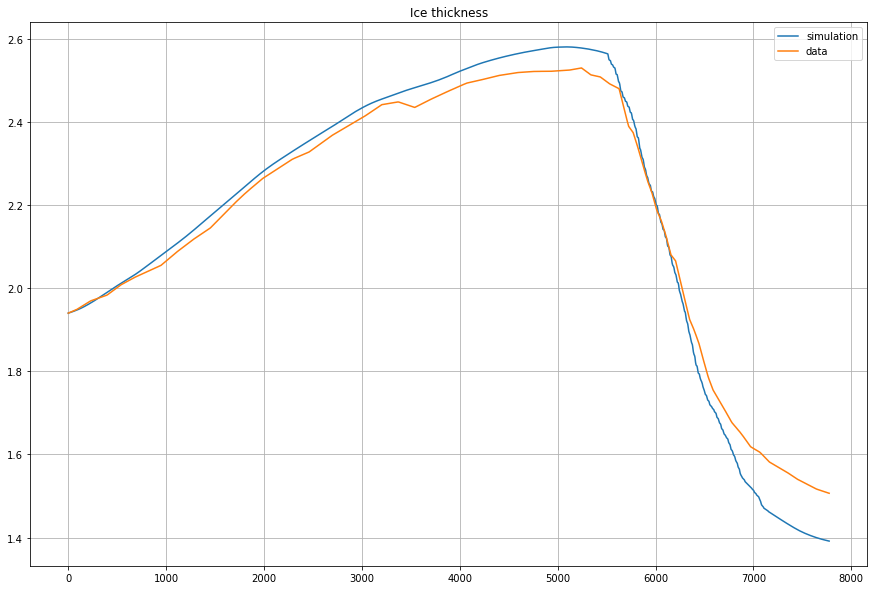

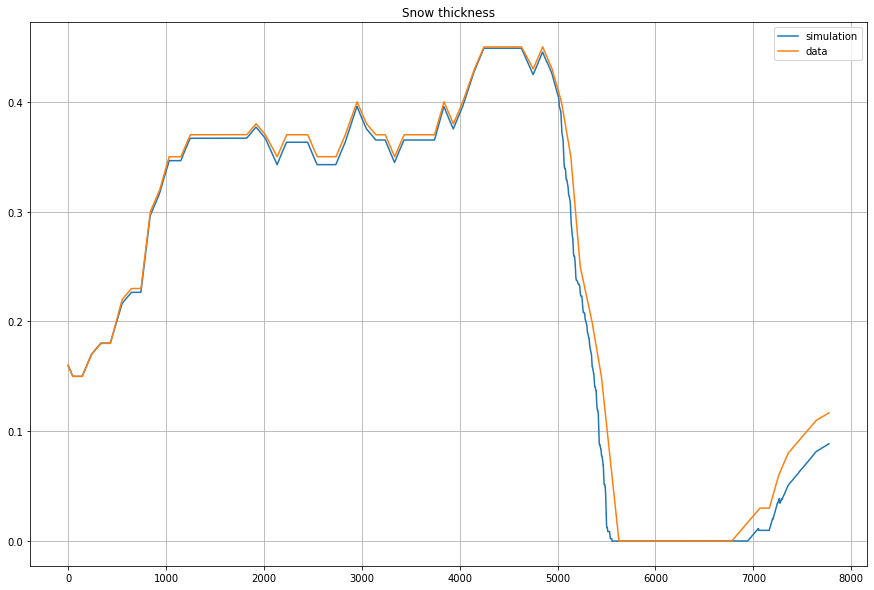

In [18]:
plot_thicknesses(data_proc_20cells, sim_proc_20cells_diff_sal)

In [19]:
uv.animate([data_proc_20cells, sim_proc_20cells[:6400]], names=['data', 'simulation'], clip_start=4000, dpi=250)

NameError: name 'sim_proc_20cells' is not defined

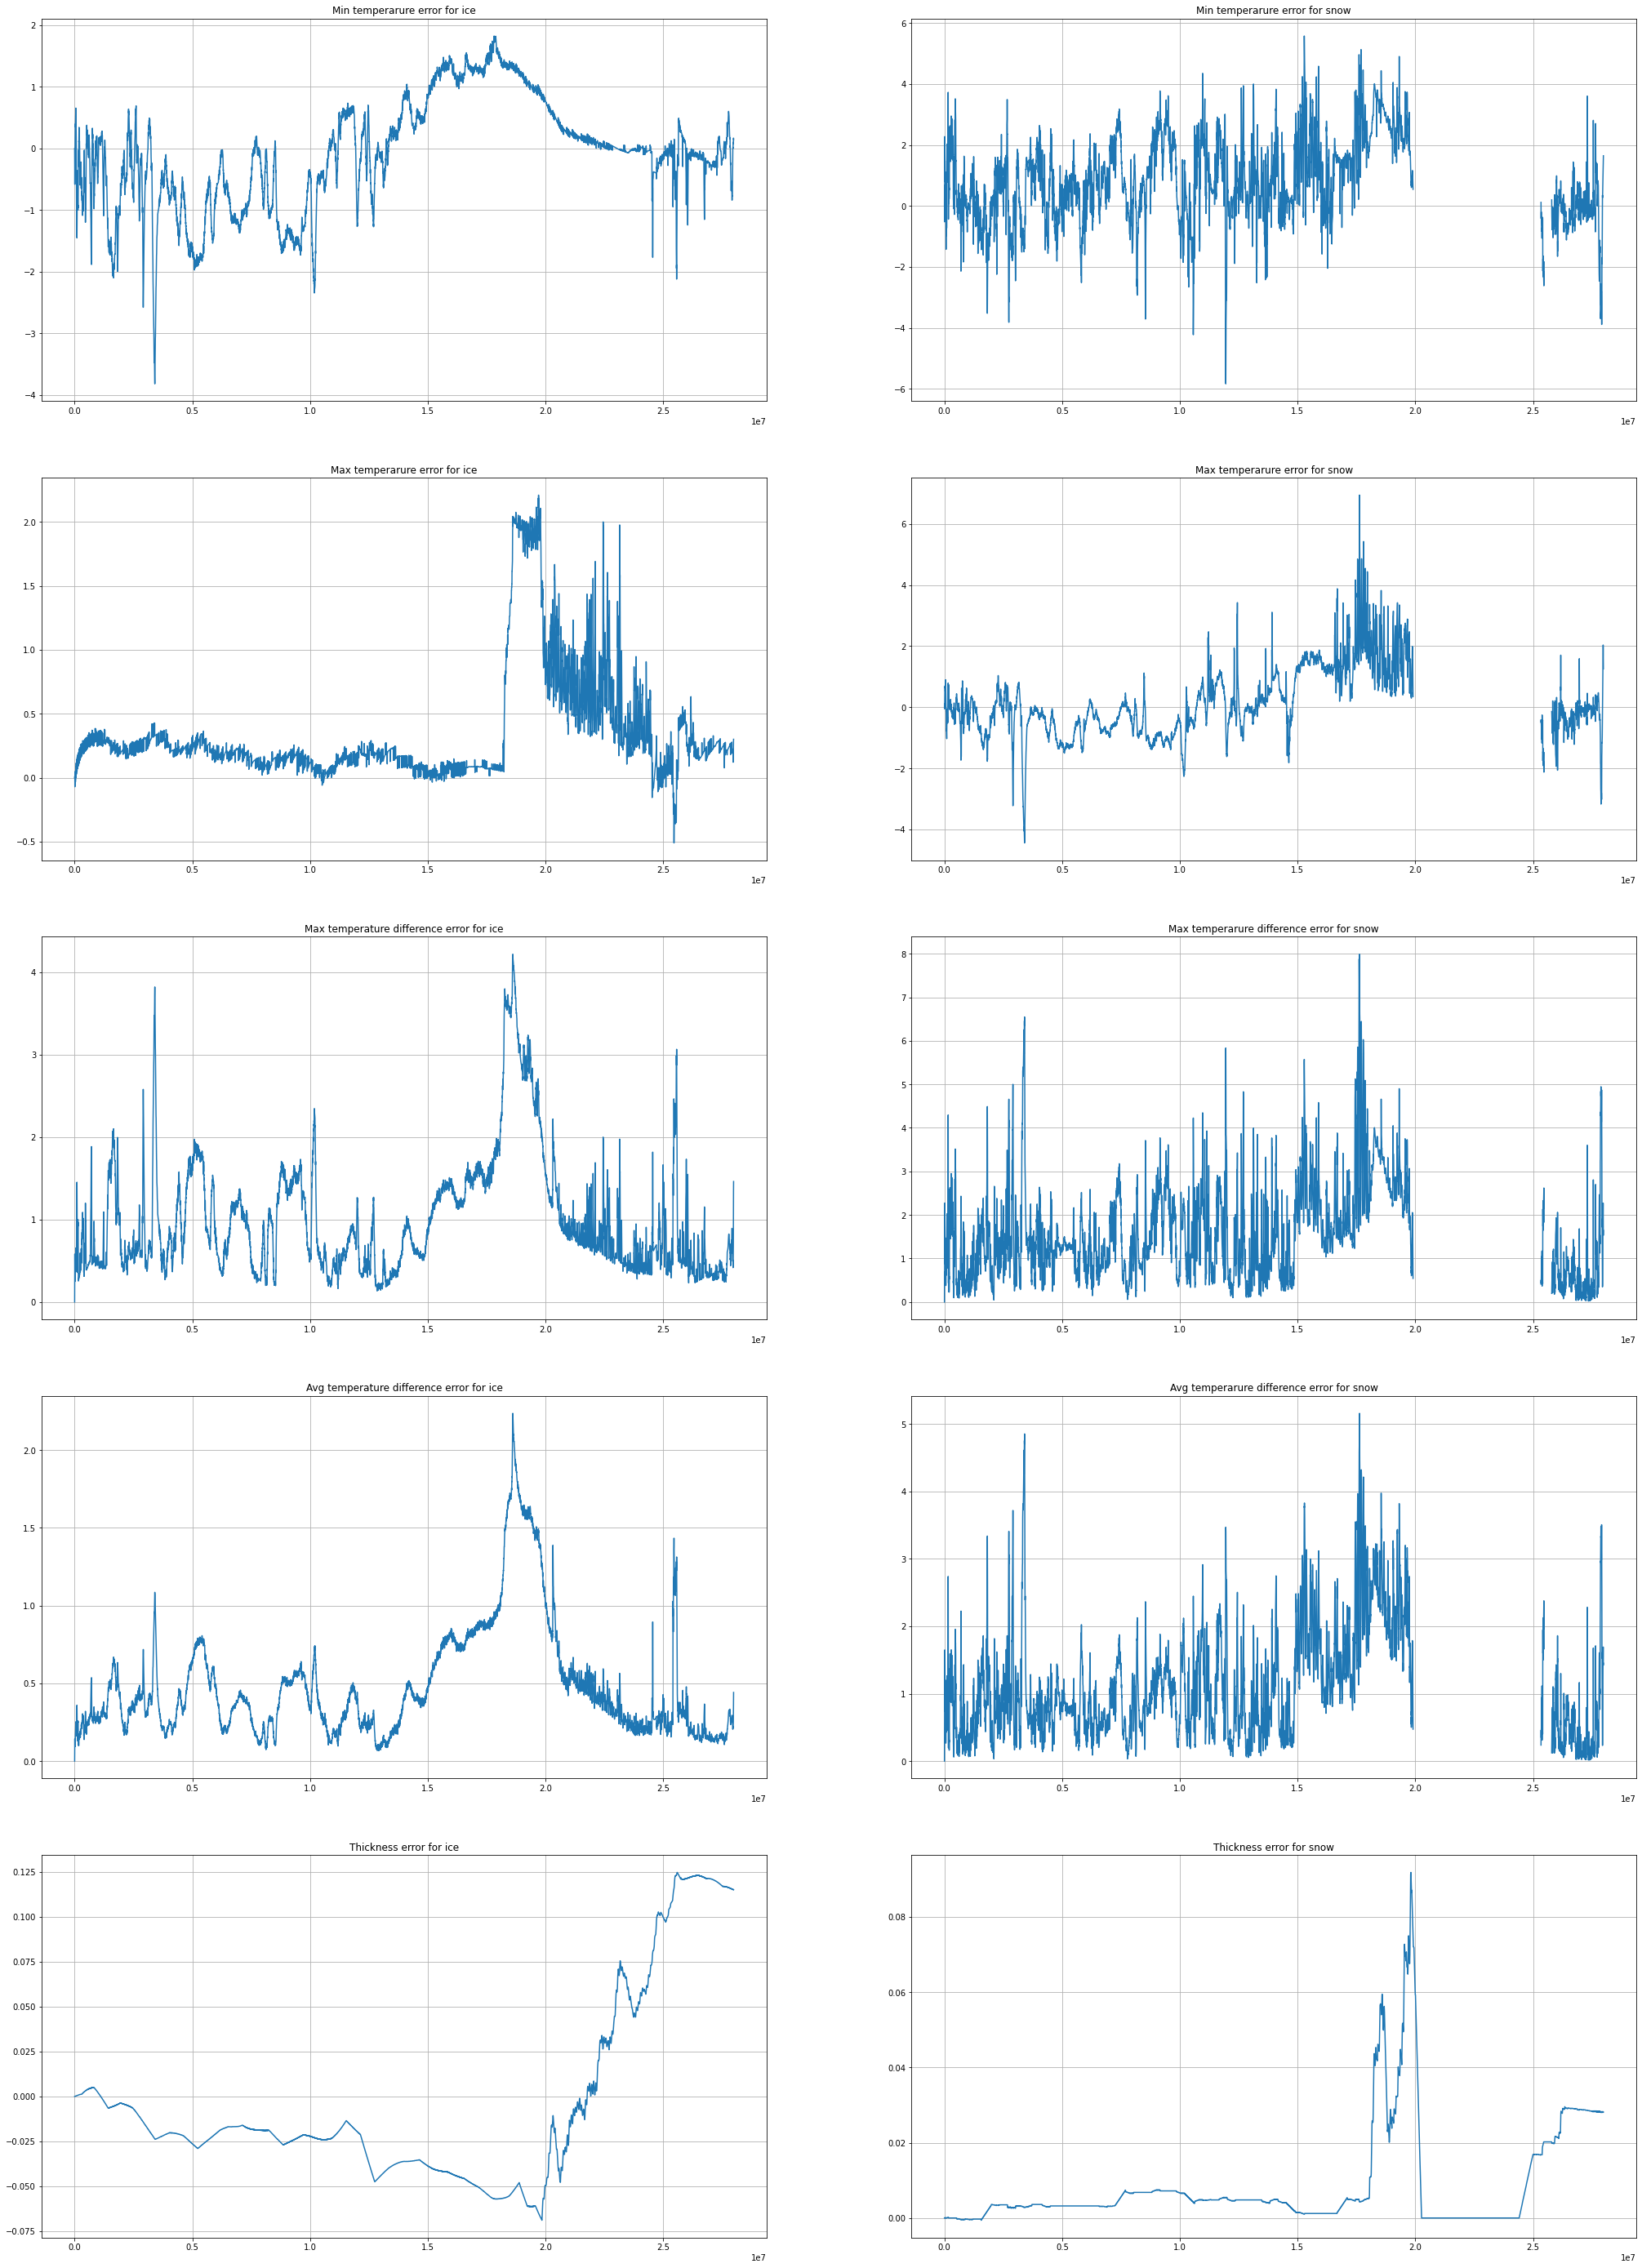

In [21]:
compare_profiles(data_proc_20cells, sim_proc_20cells_diff_sal)

In [ ]:
%%time
sim_proc_20cells_diff_sal_neg_snow = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init,
    Ts_init=T_snow_init,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=np.linspace(4.0, 1.0, len(dzi_init)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
plot_thicknesses(data_proc, sim_proc_20cells_diff_sal_neg_snow)

In [ ]:
compare_profiles(data_proc_20cells, sim_proc_20cells_diff_sal_neg_snow)

In [ ]:
# sigma mesh
dsigma_ice_40 = np.full(40, 1.0/40)
dsigma_snow_5 = np.full(5, 1.0/5)

In [ ]:
# init state from data
T_ice_init, T_snow_init, Toi_init, Tis_init, Tsa_init, \
dzi_init, dzs_init = get_init_from_data(data, dsigma_ice_40, dsigma_snow_5)

In [ ]:
# process from data
data_proc_40cells = ue.process_from_data(Z,
                                 data.loc[:, 'T_1':'T_50'].values, 
                                 data['Tib_interp'].values, data['Tis_interp'].values,
                                 data['Tss'].values,
                                 data['hi_best'].values, data['hf_best'].values,
                                 data['hs_best'].values,
                                 dsigma_ice_40, dsigma_snow_5,
                                 time_arr, ue.rho_i)

In [ ]:
%%time
sim_proc_40cells = ue.main_process \
(
    time_step=3600.0,
    time_end=7774*3600.0,
    N_pseudoiter=50,
    Ti_init=T_ice_init,
    Ts_init=T_snow_init,
    Tis_init=Tis_init,
    Tsa_init=Tsa_init,
    dzi_init=dzi_init,
    dzs_init=dzs_init,
    salinity=np.linspace(4.0, 1.0, len(dzi_init)),
    snow_thickness_threshold=0.01,
    Toi=Toi,
    Ta=T_a,
    p=p,
    F_atm_ice=F_atm_ice,
    F_atm_snow=F_atm_snow,
    F_sw=F_sw,
    F_ocn=F_ocn
)

In [ ]:
plot_thicknesses(data_proc_40cells, sim_proc)